# 푸리에, 데이터 샘플링, 스케일링, PCA을 추가한 XGBoost 모델 실험 (최적)

In [13]:
import sys
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from scipy.fft import fft, fftfreq
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV

warnings.filterwarnings('ignore')
sns.set()

if 'google.colab' in sys.modules:
    !pip install -q --upgrade xgboost
    !wget -q https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter07/exoplanets.csv.zip

!unzip -o exoplanets.csv.zip

xgb.set_config(verbosity=0)

df = pd.read_csv('exoplanets.csv', nrows=400)

# 데이터 로드 및 준비
X = df.filter(like="FLUX")  # FLUX로 시작하는 열
y = df["LABEL"] - 1  # 타깃 변수

# 1. 데이터 분할: 테스트 데이터 분리 (최종 평가용, 전체 데이터의 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 2. FFT 수행 및 진폭 계산
timestep = 1
fft_train_data = []
fft_test_data = []

for i in range(X_train.shape[0]):
    sample_flux = X_train.iloc[i, :]  # i번째 샘플
    n = len(sample_flux)

    # FFT 수행
    fft_result = fft(sample_flux.to_numpy())
    magnitude = np.abs(fft_result[:n // 2])  # 양의 주파수 성분만 사용
    fft_train_data.append(magnitude)

for i in range(X_test.shape[0]):
    sample_flux = X_test.iloc[i, :]  # i번째 샘플
    n = len(sample_flux)

    # FFT 수행
    fft_result = fft(sample_flux.to_numpy())
    magnitude = np.abs(fft_result[:n // 2])  # 양의 주파수 성분만 사용
    fft_test_data.append(magnitude)

# FFT 결과를 DataFrame으로 변환
fft_train_df = pd.DataFrame(fft_train_data)
fft_test_df = pd.DataFrame(fft_test_data)

# 3. 데이터 샘플링: SMOTE + Tomek Links 사용 (훈련 데이터에 대해서만 적용)
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(fft_train_df, y_train)

# 4. 데이터 스케일링 (훈련-검증 데이터에 대해서만 스케일링 적용)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(fft_test_df)

# PCA 수행 및 주성분 선택
pca = PCA(n_components=10)
principal_components = pca.fit_transform(X_train_scaled)

# PCA 결과를 DataFrame으로 변환하고 원하는 주성분 선택
pca_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])
# X_train_pca_selected = pca_df[['PC1', 'PC2', 'PC4', 'PC8', 'PC5']]  # 임의로 선택한 주성분 사용
X_test_pca_selected = pca_df[['PC2', 'PC5', 'PC7', 'PC9', 'PC10']] # 최적의 조합으로 선택된 주성분 사용

# 테스트 데이터에도 동일한 PCA 변환 적용 후 원하는 주성분 선택
X_test_pca = pca.transform(X_test_scaled)
X_test_pca_df = pd.DataFrame(X_test_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])
# X_test_pca_selected = X_test_pca_df[['PC1', 'PC2', 'PC4', 'PC8', 'PC5']]  # 임의로 선택한 주성분 사용
X_test_pca_selected = X_test_pca_df[['PC2', 'PC5', 'PC7', 'PC9', 'PC10']] # 최적의 조합으로 선택된 주성분 사용

# 5. Stratified K-Fold Cross Validation 설정 (훈련-검증 데이터만 사용)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 모델 정의
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Cross Validation 학습 및 평가
validation_scores = []

for train_index, val_index in skf.split(X_train_pca_selected, y_train_resampled):
    # 훈련-검증 데이터 분할
    X_train, X_val = X_train_pca_selected.iloc[train_index], X_train_pca_selected.iloc[val_index]
    y_train, y_val = y_train_resampled.iloc[train_index], y_train_resampled.iloc[val_index]

    # 모델 학습
    model.fit(X_train, y_train)

    # 검증 데이터로 성능 평가
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    validation_scores.append(val_accuracy)

    print(f"Validation Accuracy: {val_accuracy:.4f}")

# 교차 검증 평균 성능 출력
print("\n=== Cross Validation Results ===")
print(f"Mean Validation Accuracy: {np.mean(validation_scores):.4f}")
print(f"Validation Accuracy Standard Deviation: {np.std(validation_scores):.4f}")

# 6. 최종 모델 학습 및 테스트 평가
model.fit(X_train_pca_selected, y_train_resampled)  # 전체 훈련-검증 데이터로 학습

# 테스트 데이터 평가
y_test_pred = model.predict(X_test_pca_selected)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("\n=== Final Test Set Evaluation ===")
print("Accuracy:", test_accuracy)  # 테스트 세트 정확도 출력
print("Classification Report:\n", classification_report(y_test, y_test_pred))  # 상세 성능 출력

# 혼동 행렬 출력
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("\n=== Confusion Matrix ===")
print(conf_matrix)

# 7. 하이퍼파라미터 튜닝을 위한 추가 코드
# RandomizedSearchCV 설정
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.4],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 1],  # L1 regularization
    'reg_lambda': [0.5, 1, 5]  # L2 regularization
}

random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=2,
    random_state=42
)

# 하이퍼파라미터 최적화 수행
random_search.fit(X_train_pca_selected, y_train_resampled)

# 최적의 하이퍼파라미터 및 최적의 모델로 테스트 데이터 평가
print("\n=== Best Parameters from Randomized Search ===")
print(random_search.best_params_)

# 최적 모델로 테스트 평가
best_model = random_search.best_estimator_
y_test_pred = best_model.predict(X_test_pca_selected)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\n=== Final Test Set Evaluation with Best Parameters ===")
print("Accuracy:", test_accuracy)
print("Classification Report:\n", classification_report(y_test, y_test_pred))

# 혼동 행렬 출력
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("\n=== Confusion Matrix ===")
print(conf_matrix)

Archive:  exoplanets.csv.zip
  inflating: exoplanets.csv          
  inflating: __MACOSX/._exoplanets.csv  
Validation Accuracy: 0.9052
Validation Accuracy: 0.8276
Validation Accuracy: 0.8534
Validation Accuracy: 0.8534
Validation Accuracy: 0.8534

=== Cross Validation Results ===
Mean Validation Accuracy: 0.8586
Validation Accuracy Standard Deviation: 0.0253


ValueError: feature_names mismatch: ['PC1', 'PC2', 'PC4', 'PC8', 'PC5'] ['PC2', 'PC5', 'PC7', 'PC9', 'PC10']
expected PC8, PC1, PC4 in input data
training data did not have the following fields: PC10, PC7, PC9

# 푸리에, 데이터 샘플링, 스케일링을 추가한 LSTM 모델 실험

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 40.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
Archive:  exoplanets.csv.zip
  inflating: exoplanets.csv          
   creating: __MACOSX/
  inflating: __MACOSX/._exoplanets.csv  
Epoch 1/50
15/15 - 15s - 1s/step - accuracy: 0.5970 - loss: 0.6783 - val_accuracy: 0.0000e+00 - val_loss: 0.8138
Epoch 2/50
15/15 - 19s - 1s/step - accuracy: 0.6272 - loss: 0.6461 - val_accuracy: 0.0000e+00 - val_loss: 0.9534
Epoch 3/50
15/15 - 21s - 1s/step - accuracy: 0.6358 - loss: 0.6367 - val_accuracy: 0.0776 - val_loss: 0.8731
Epoch 4/50
15/15 - 21s - 1s/step - accuracy: 0.6272 - loss: 0.6268 - val_accuracy: 0.0603 - val_los

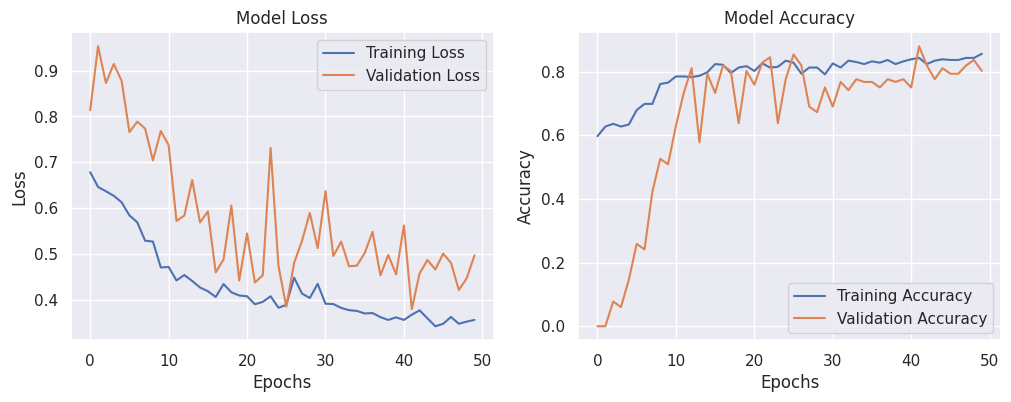

In [ ]:
import sys
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.combine import SMOTETomek

warnings.filterwarnings('ignore')
sns.set()

if 'google.colab' in sys.modules:
    !pip install -q --upgrade tensorflow
    !wget -q https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter07/exoplanets.csv.zip

!unzip -o exoplanets.csv.zip

df = pd.read_csv('exoplanets.csv', nrows=400)

# 데이터 로드 및 준비
X = df.filter(like="FLUX")  # FLUX로 시작하는 열
y = df["LABEL"] - 1  # 타깃 변수

# 1. 데이터 분할: 테스트 데이터 분리 (최종 평가용, 전체 데이터의 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 2. FFT 수행 및 진폭 계산
timestep = 1
fft_train_data = []
fft_test_data = []

for i in range(X_train.shape[0]):
    sample_flux = X_train.iloc[i, :]  # i번째 샘플
    n = len(sample_flux)

    # FFT 수행
    fft_result = np.fft.fft(sample_flux.to_numpy())
    magnitude = np.abs(fft_result[:n // 2])  # 양의 주파수 성분만 사용
    fft_train_data.append(magnitude)

for i in range(X_test.shape[0]):
    sample_flux = X_test.iloc[i, :]  # i번째 샘플
    n = len(sample_flux)

    # FFT 수행
    fft_result = np.fft.fft(sample_flux.to_numpy())
    magnitude = np.abs(fft_result[:n // 2])  # 양의 주파수 성분만 사용
    fft_test_data.append(magnitude)

# FFT 결과를 DataFrame으로 변환
fft_train_df = pd.DataFrame(fft_train_data)
fft_test_df = pd.DataFrame(fft_test_data)

# 3. 데이터 샘플링: SMOTE + Tomek Links 사용 (훈련 데이터에 대해서만 적용)
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(fft_train_df, y_train)

# 4. 데이터 스케일링 (훈련-검증 데이터에 대해서만 스케일링 적용)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(fft_test_df)

# 5. LSTM 모델을 위한 데이터 형상 변경
# LSTM은 3차원 입력을 필요로 하므로 (샘플 수, 타임스텝 수, 특성 수) 형태로 변경합니다.
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# 6. LSTM 모델 정의
model = Sequential()
model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], 1), activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 7. 모델 학습
history = model.fit(X_train_lstm, y_train_resampled, epochs=50, batch_size=32, validation_split=0.2, verbose=2)

# 8. 테스트 데이터 평가
y_test_pred_prob = model.predict(X_test_lstm)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).reshape(-1)

# 정확도 및 분류 보고서 출력
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\n=== Final Test Set Evaluation ===")
print("Accuracy:", test_accuracy)
print("Classification Report:\n", classification_report(y_test, y_test_pred))

# 혼동 행렬 출력
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("\n=== Confusion Matrix ===")
print(conf_matrix)

# 모델 학습 과정 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 푸리에, 데이터 샘플링, 스케일링을 추가한 GRU 모델 실험

Archive:  exoplanets.csv.zip
  inflating: exoplanets.csv          
  inflating: __MACOSX/._exoplanets.csv  
Epoch 1/50
15/15 - 21s - 1s/step - accuracy: 0.6121 - loss: 0.6872 - val_accuracy: 0.0517 - val_loss: 0.7759
Epoch 2/50
15/15 - 17s - 1s/step - accuracy: 0.6379 - loss: 0.6547 - val_accuracy: 0.0517 - val_loss: 0.8421
Epoch 3/50
15/15 - 19s - 1s/step - accuracy: 0.6315 - loss: 0.6384 - val_accuracy: 0.0431 - val_loss: 0.9668
Epoch 4/50
15/15 - 15s - 1s/step - accuracy: 0.6509 - loss: 0.6168 - val_accuracy: 0.2500 - val_loss: 0.8671
Epoch 5/50
15/15 - 20s - 1s/step - accuracy: 0.6595 - loss: 0.6005 - val_accuracy: 0.2414 - val_loss: 0.8651
Epoch 6/50
15/15 - 22s - 1s/step - accuracy: 0.6918 - loss: 0.5743 - val_accuracy: 0.3362 - val_loss: 0.7397
Epoch 7/50
15/15 - 22s - 1s/step - accuracy: 0.7004 - loss: 0.5477 - val_accuracy: 0.3707 - val_loss: 0.7396
Epoch 8/50
15/15 - 18s - 1s/step - accuracy: 0.7047 - loss: 0.5317 - val_accuracy: 0.4655 - val_loss: 0.6504
Epoch 9/50
15/15 - 1

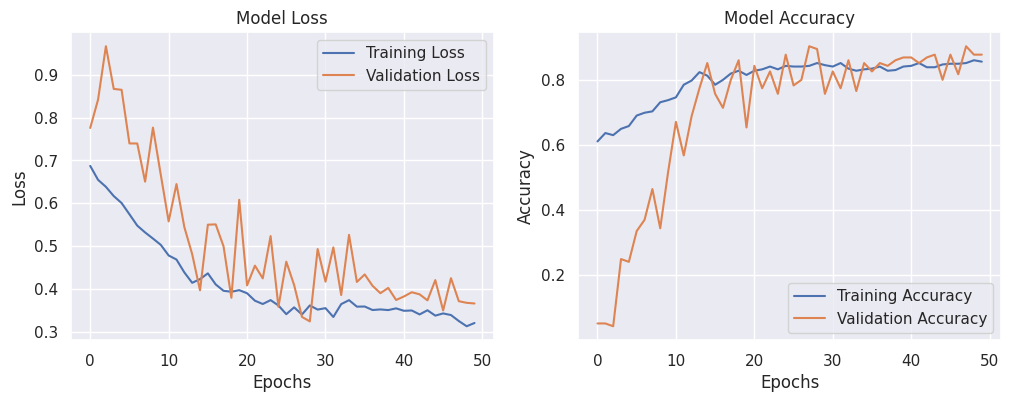

In [ ]:
import sys
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.combine import SMOTETomek

warnings.filterwarnings('ignore')
sns.set()

if 'google.colab' in sys.modules:
    !pip install -q --upgrade tensorflow
    !wget -q https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter07/exoplanets.csv.zip

!unzip -o exoplanets.csv.zip

df = pd.read_csv('exoplanets.csv', nrows=400)

# 데이터 로드 및 준비
X = df.filter(like="FLUX")  # FLUX로 시작하는 열
y = df["LABEL"] - 1  # 타깃 변수

# 1. 데이터 분할: 테스트 데이터 분리 (최종 평가용, 전체 데이터의 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 2. FFT 수행 및 진폭 계산
timestep = 1
fft_train_data = []
fft_test_data = []

for i in range(X_train.shape[0]):
    sample_flux = X_train.iloc[i, :]  # i번째 샘플
    n = len(sample_flux)

    # FFT 수행
    fft_result = np.fft.fft(sample_flux.to_numpy())
    magnitude = np.abs(fft_result[:n // 2])  # 양의 주파수 성분만 사용
    fft_train_data.append(magnitude)

for i in range(X_test.shape[0]):
    sample_flux = X_test.iloc[i, :]  # i번째 샘플
    n = len(sample_flux)

    # FFT 수행
    fft_result = np.fft.fft(sample_flux.to_numpy())
    magnitude = np.abs(fft_result[:n // 2])  # 양의 주파수 성분만 사용
    fft_test_data.append(magnitude)

# FFT 결과를 DataFrame으로 변환
fft_train_df = pd.DataFrame(fft_train_data)
fft_test_df = pd.DataFrame(fft_test_data)

# 3. 데이터 샘플링: SMOTE + Tomek Links 사용 (훈련 데이터에 대해서만 적용)
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(fft_train_df, y_train)

# 4. 데이터 스케일링 (훈련-검증 데이터에 대해서만 스케일링 적용)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(fft_test_df)

X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# 6. GRU 모델 정의
model = Sequential()
model.add(GRU(64, input_shape=(X_train_scaled.shape[1], 1), activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 7. 모델 학습
history = model.fit(X_train_scaled, y_train_resampled, epochs=50, batch_size=32, validation_split=0.2, verbose=2)

# 8. 테스트 데이터 평가
y_test_pred_prob = model.predict(X_test_scaled)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).reshape(-1)

# 정확도 및 분류 보고서 출력
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\n=== Final Test Set Evaluation ===")
print("Accuracy:", test_accuracy)
print("Classification Report:\n", classification_report(y_test, y_test_pred))

# 혼동 행렬 출력
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("\n=== Confusion Matrix ===")
print(conf_matrix)

# 모델 학습 과정 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 순정 데이터셋을 가지고 XGBoost, LSTM, GRU 모델 실험

In [ ]:
import sys
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import History
import tensorflow as tf

warnings.filterwarnings('ignore')
sns.set()

xgb.set_config(verbosity=0)

df = pd.read_csv('exoplanets.csv', nrows=400)

# 데이터 로드 및 준비
X = df.filter(like="FLUX")  # FLUX로 시작하는 열
y = df["LABEL"] - 1  # 타깃 변수

# 1. 데이터 분할: 테스트 데이터 분리 (최종 평가용, 전체 데이터의 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 5. Stratified K-Fold Cross Validation 설정 (훈련-검증 데이터만 사용)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 1. XGBoost 모델 학습 및 평가
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=5)
validation_scores = []

for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    xgb_model.fit(X_train_fold, y_train_fold)
    y_val_pred = xgb_model.predict(X_val_fold)
    val_accuracy = accuracy_score(y_val_fold, y_val_pred)
    validation_scores.append(val_accuracy)
    print(f"XGBoost Validation Accuracy: {val_accuracy:.4f}")

print("\n=== XGBoost Cross Validation Results ===")
print(f"Mean Validation Accuracy: {np.mean(validation_scores):.4f}")
print(f"Validation Accuracy Standard Deviation: {np.std(validation_scores):.4f}")

# 2. LSTM 모델 학습 및 평가
X_train_lstm = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(X_train.shape[1], 1), activation='tanh'))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

history = lstm_model.fit(X_train_lstm, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=2)

y_test_pred = (lstm_model.predict(X_test_lstm) > 0.5).astype(int).reshape(-1)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\n=== LSTM Final Test Set Evaluation ===")
print("Accuracy:", test_accuracy)
print("Classification Report:\n", classification_report(y_test, y_test_pred))

# 3. GRU 모델 학습 및 평가
gru_model = Sequential()
gru_model.add(GRU(64, input_shape=(X_train.shape[1], 1), activation='tanh'))
gru_model.add(Dropout(0.3))
gru_model.add(Dense(1, activation='sigmoid'))
gru_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

history = gru_model.fit(X_train_lstm, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=2)

y_test_pred = (gru_model.predict(X_test_lstm) > 0.5).astype(int).reshape(-1)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\n=== GRU Final Test Set Evaluation ===")
print("Accuracy:", test_accuracy)
print("Classification Report:\n", classification_report(y_test, y_test_pred))

# 하이퍼파라미터 튜닝: RandomizedSearchCV (XGBoost만 적용)
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.4],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0.5, 1, 5]
}

random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

print("\n=== Best Parameters from Randomized Search ===")
print(random_search.best_params_)

best_model = random_search.best_estimator_
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\n=== Final Test Set Evaluation with Best Parameters ===")
print("Accuracy:", test_accuracy)
print("Classification Report:\n", classification_report(y_test, y_test_pred))


XGBoost Validation Accuracy: 0.9062
XGBoost Validation Accuracy: 0.8594
XGBoost Validation Accuracy: 0.9062
XGBoost Validation Accuracy: 0.9062
XGBoost Validation Accuracy: 0.8750

=== XGBoost Cross Validation Results ===
Mean Validation Accuracy: 0.8906
Validation Accuracy Standard Deviation: 0.0198
Epoch 1/5
8/8 - 12s - 2s/step - accuracy: 0.7500 - loss: 0.5648 - val_accuracy: 0.8906 - val_loss: 0.4755
Epoch 2/5
8/8 - 11s - 1s/step - accuracy: 0.9062 - loss: 0.4193 - val_accuracy: 0.8906 - val_loss: 0.3918
Epoch 3/5
8/8 - 19s - 2s/step - accuracy: 0.9102 - loss: 0.3475 - val_accuracy: 0.8906 - val_loss: 0.3631
Epoch 4/5
8/8 - 10s - 1s/step - accuracy: 0.9102 - loss: 0.3111 - val_accuracy: 0.8906 - val_loss: 0.3569
Epoch 5/5
8/8 - 12s - 2s/step - accuracy: 0.9102 - loss: 0.2899 - val_accuracy: 0.8906 - val_loss: 0.3624


2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 419ms/step

=== LSTM Final Test Set Evaluation ===
Accuracy: 0.9125
Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        73
           1       0.00      0.00      0.00         7

    accuracy                           0.91        80
   macro avg       0.46      0.50      0.48        80
weighted avg       0.83      0.91      0.87        80

Epoch 1/5
8/8 - 15s - 2s/step - accuracy: 0.5039 - loss: 0.8194 - val_accuracy: 0.7344 - val_loss: 0.5440
Epoch 2/5
8/8 - 19s - 2s/step - accuracy: 0.7891 - loss: 0.5007 - val_accuracy: 0.8906 - val_loss: 0.4437
Epoch 3/5
8/8 - 21s - 3s/step - accuracy: 0.8711 - loss: 0.3786 - val_accuracy: 0.8906 - val_loss: 0.4368
Epoch 4/5
8/8 - 20s - 3s/step - accuracy: 0.8945 - loss: 0.4013 - val_accuracy: 0.8906 - val_loss: 0.4357
Epoch 5/5
8/8 - 20s - 3s/step - accuracy: 0.8984 - loss: 0.3585 - val_accuracy: 0.8906 - val_loss: 0.4285
3/3 ━━━━━━━━━━━━━━━━━━━

# 푸리에, 데이터 샘플링, 스케일링, PCA를 추가한 GRU 모델 실험

In [ ]:
import sys
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.combine import SMOTETomek

warnings.filterwarnings('ignore')
sns.set()

# if 'google.colab' in sys.modules:
#     !pip install -q --upgrade tensorflow
#     !wget -q https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter07/exoplanets.csv.zip

# !unzip -o exoplanets.csv.zip

df = pd.read_csv('exoplanets.csv', nrows=400)

# 데이터 로드 및 준비
X = df.filter(like="FLUX")  # FLUX로 시작하는 열
y = df["LABEL"] - 1  # 타깃 변수

# 1. Stratified K-Fold 분할
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
fold_accuracies = []
conf_matrices = []

# FFT 및 데이터 전처리 함수 정의
def compute_fft(data):
    fft_data = []
    for i in range(data.shape[0]):
        sample_flux = data.iloc[i, :]
        n = len(sample_flux)

        # FFT 수행
        fft_result = np.fft.fft(sample_flux.to_numpy())
        magnitude = np.abs(fft_result[:n // 2])  # 양의 주파수 성분만 사용
        fft_data.append(magnitude)
    return pd.DataFrame(fft_data)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}/{n_splits}")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # 2. FFT 수행 및 진폭 계산
    fft_train_df = compute_fft(X_train)
    fft_val_df = compute_fft(X_val)

    # 3. 데이터 샘플링: SMOTE + Tomek Links 사용 (훈련 데이터에 대해서만 적용)
    smote_tomek = SMOTETomek(random_state=42)
    X_train_resampled, y_train_resampled = smote_tomek.fit_resample(fft_train_df, y_train)

    # 4. PCA 적용
    pca = PCA(n_components=0.95)  # 분산의 95%를 유지하도록 구성
    X_train_pca = pca.fit_transform(X_train_resampled)
    X_val_pca = pca.transform(fft_val_df)

    # 5. 데이터 스케일링 (훈련-검증 데이터에 대해서만 스케일링 적용)
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_pca)
    X_val_scaled = scaler.transform(X_val_pca)

    # GRU 모델 입력을 위해 3차원 형태로 변환
    X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
    X_val_scaled = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))

    # 6. GRU 모델 정의
    model = Sequential()
    model.add(GRU(64, input_shape=(X_train_scaled.shape[1], 1), activation='tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # 7. 모델 학습
    history = model.fit(X_train_scaled, y_train_resampled, epochs=50, batch_size=32, validation_data=(X_val_scaled, y_val), verbose=2)

    # 8. 검증 데이터 평가
    y_val_pred_prob = model.predict(X_val_scaled)
    y_val_pred = (y_val_pred_prob > 0.5).astype(int).reshape(-1)

    # 정확도 및 혼동 행렬 측정
    val_accuracy = accuracy_score(y_val, y_val_pred)
    fold_accuracies.append(val_accuracy)
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    conf_matrices.append(conf_matrix)
    print(f"Fold {fold + 1} Accuracy: {val_accuracy}\n")
    print(f"Confusion Matrix for Fold {fold + 1}:\n{conf_matrix}\n")

# 최종 결과 보고
print("\n=== Cross-Validation Results ===")
print("Fold Accuracies:", fold_accuracies)
print("Mean Accuracy:", np.mean(fold_accuracies))

# 각 폴드의 혼동 행렬 출력
print("\n=== Confusion Matrices for Each Fold ===")
for i, matrix in enumerate(conf_matrices):
    print(f"Fold {i + 1} Confusion Matrix:\n{matrix}\n")

# 최종 테스트 세트 평가
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
fft_train_full_df = compute_fft(X_train_full)
fft_test_df = compute_fft(X_test)
X_train_resampled_full, y_train_resampled_full = smote_tomek.fit_resample(fft_train_full_df, y_train_full)
X_train_pca_full = pca.fit_transform(X_train_resampled_full)
X_test_pca = pca.transform(fft_test_df)
X_train_scaled_full = scaler.fit_transform(X_train_pca_full)
X_test_scaled = scaler.transform(X_test_pca)
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# 모델 학습 (전체 데이터 사용)
model = Sequential()
model.add(GRU(64, input_shape=(X_train_scaled_full.shape[1], 1), activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_scaled_full, y_train_resampled_full, epochs=50, batch_size=32, validation_split=0.2, verbose=2)

# 테스트 데이터 평가
y_test_pred_prob = model.predict(X_test_scaled)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).reshape(-1)

# 정확도 및 분류 보고서 출력
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\n=== Final Test Set Evaluation ===")
print("Accuracy:", test_accuracy)
print("Classification Report:\n", classification_report(y_test, y_test_pred))

# 혼동 행렬 출력
conf_matrix_final = confusion_matrix(y_test, y_test_pred)
print("\n=== Confusion Matrix ===")
print(conf_matrix_final)

Fold 1/5
Epoch 1/50
19/19 - 8s - 419ms/step - accuracy: 0.4931 - loss: 0.7220 - val_accuracy: 0.3875 - val_loss: 0.6934
Epoch 2/50
19/19 - 1s - 28ms/step - accuracy: 0.5292 - loss: 0.6795 - val_accuracy: 0.4125 - val_loss: 0.6988
Epoch 3/50
19/19 - 1s - 34ms/step - accuracy: 0.5790 - loss: 0.6704 - val_accuracy: 0.4250 - val_loss: 0.6941
Epoch 4/50
19/19 - 1s - 29ms/step - accuracy: 0.5447 - loss: 0.6643 - val_accuracy: 0.8375 - val_loss: 0.6590
Epoch 5/50
19/19 - 1s - 29ms/step - accuracy: 0.5722 - loss: 0.6532 - val_accuracy: 0.8125 - val_loss: 0.6595
Epoch 6/50
19/19 - 1s - 38ms/step - accuracy: 0.5808 - loss: 0.6461 - val_accuracy: 0.8500 - val_loss: 0.6406
Epoch 7/50
19/19 - 1s - 59ms/step - accuracy: 0.6014 - loss: 0.6342 - val_accuracy: 0.7875 - val_loss: 0.6520
Epoch 8/50
19/19 - 1s - 29ms/step - accuracy: 0.6357 - loss: 0.6265 - val_accuracy: 0.8500 - val_loss: 0.6308
Epoch 9/50
19/19 - 1s - 28ms/step - accuracy: 0.6306 - loss: 0.6148 - val_accuracy: 0.8500 - val_loss: 0.6083


# 푸리에, 데이터 샘플링, 스케일링, PCA를 추가한 LSTM 모델 실험

In [ ]:
import sys
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.combine import SMOTETomek

warnings.filterwarnings('ignore')
sns.set()

if 'google.colab' in sys.modules:
    !pip install -q --upgrade tensorflow
    !wget -q https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter07/exoplanets.csv.zip

!unzip -o exoplanets.csv.zip

df = pd.read_csv('exoplanets.csv', nrows=400)

# 데이터 로드 및 준비
X = df.filter(like="FLUX")  # FLUX로 시작하는 열
y = df["LABEL"] - 1  # 타깃 변수

# 1. Stratified K-Fold 분할
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
fold_accuracies = []
conf_matrices = []

# FFT 및 데이터 전처리 함수 정의
def compute_fft(data):
    fft_data = []
    for i in range(data.shape[0]):
        sample_flux = data.iloc[i, :]
        n = len(sample_flux)

        # FFT 수행
        fft_result = np.fft.fft(sample_flux.to_numpy())
        magnitude = np.abs(fft_result[:n // 2])  # 양의 주파수 성분만 사용
        fft_data.append(magnitude)
    return pd.DataFrame(fft_data)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}/{n_splits}")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # 2. FFT 수행 및 진폭 계산
    fft_train_df = compute_fft(X_train)
    fft_val_df = compute_fft(X_val)

    # 3. 데이터 샘플링: SMOTE + Tomek Links 사용 (훈련 데이터에 대해서만 적용)
    smote_tomek = SMOTETomek(random_state=42)
    X_train_resampled, y_train_resampled = smote_tomek.fit_resample(fft_train_df, y_train)

    # 4. PCA 적용
    pca = PCA(n_components=0.95)  # 분산의 95%를 유지하도록 구성
    X_train_pca = pca.fit_transform(X_train_resampled)
    X_val_pca = pca.transform(fft_val_df)

    # 5. 데이터 스케일링 (훈련-검증 데이터에 대해서만 스케일링 적용)
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_pca)
    X_val_scaled = scaler.transform(X_val_pca)

    # LSTM 모델 입력을 위해 3차원 형태로 변환
    X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
    X_val_scaled = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))

    # 6. LSTM 모델 정의
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train_scaled.shape[1], 1), activation='tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # 7. 모델 학습
    history = model.fit(X_train_scaled, y_train_resampled, epochs=50, batch_size=32, validation_data=(X_val_scaled, y_val), verbose=2)

    # 8. 검증 데이터 평가
    y_val_pred_prob = model.predict(X_val_scaled)
    y_val_pred = (y_val_pred_prob > 0.5).astype(int).reshape(-1)

    # 정확도 및 혼동 행렬 측정
    val_accuracy = accuracy_score(y_val, y_val_pred)
    fold_accuracies.append(val_accuracy)
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    conf_matrices.append(conf_matrix)
    print(f"Fold {fold + 1} Accuracy: {val_accuracy}\n")
    print(f"Confusion Matrix for Fold {fold + 1}:\n{conf_matrix}\n")

# 최종 결과 보고
print("\n=== Cross-Validation Results ===")
print("Fold Accuracies:", fold_accuracies)
print("Mean Accuracy:", np.mean(fold_accuracies))

# 각 폴드의 혼동 행렬 출력
print("\n=== Confusion Matrices for Each Fold ===")
for i, matrix in enumerate(conf_matrices):
    print(f"Fold {i + 1} Confusion Matrix:\n{matrix}\n")

# 최종 테스트 세트 평가
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
fft_train_full_df = compute_fft(X_train_full)
fft_test_df = compute_fft(X_test)
X_train_resampled_full, y_train_resampled_full = smote_tomek.fit_resample(fft_train_full_df, y_train_full)
X_train_pca_full = pca.fit_transform(X_train_resampled_full)
X_test_pca = pca.transform(fft_test_df)
X_train_scaled_full = scaler.fit_transform(X_train_pca_full)
X_test_scaled = scaler.transform(X_test_pca)
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# 모델 학습 (전체 데이터 사용)
model = Sequential()
model.add(LSTM(64, input_shape=(X_train_scaled_full.shape[1], 1), activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_scaled_full, y_train_resampled_full, epochs=50, batch_size=32, validation_split=0.2, verbose=2)

# 테스트 데이터 평가
y_test_pred_prob = model.predict(X_test_scaled)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).reshape(-1)

# 정확도 및 분류 보고서 출력
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\n=== Final Test Set Evaluation ===")
print("Accuracy:", test_accuracy)
print("Classification Report:\n", classification_report(y_test, y_test_pred))

# 혼동 행렬 출력
conf_matrix_final = confusion_matrix(y_test, y_test_pred)
print("\n=== Confusion Matrix ===")
print(conf_matrix_final)

Archive:  exoplanets.csv.zip
  inflating: exoplanets.csv          
  inflating: __MACOSX/._exoplanets.csv  
Fold 1/5
Epoch 1/50
19/19 - 4s - 199ms/step - accuracy: 0.5172 - loss: 0.6930 - val_accuracy: 0.8875 - val_loss: 0.6797
Epoch 2/50
19/19 - 0s - 16ms/step - accuracy: 0.5619 - loss: 0.6740 - val_accuracy: 0.7625 - val_loss: 0.6782
Epoch 3/50
19/19 - 0s - 20ms/step - accuracy: 0.5550 - loss: 0.6659 - val_accuracy: 0.6500 - val_loss: 0.6744
Epoch 4/50
19/19 - 0s - 14ms/step - accuracy: 0.5636 - loss: 0.6570 - val_accuracy: 0.8250 - val_loss: 0.6704
Epoch 5/50
19/19 - 0s - 14ms/step - accuracy: 0.5636 - loss: 0.6479 - val_accuracy: 0.8750 - val_loss: 0.6550
Epoch 6/50
19/19 - 0s - 15ms/step - accuracy: 0.5704 - loss: 0.6440 - val_accuracy: 0.8500 - val_loss: 0.6600
Epoch 7/50
19/19 - 0s - 15ms/step - accuracy: 0.5876 - loss: 0.6387 - val_accuracy: 0.8750 - val_loss: 0.6385
Epoch 8/50
19/19 - 0s - 13ms/step - accuracy: 0.5773 - loss: 0.6317 - val_accuracy: 0.8500 - val_loss: 0.6520
Ep

In [24]:
import sys
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from scipy.fft import fft, fftfreq
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV

warnings.filterwarnings('ignore')
sns.set()

if 'google.colab' in sys.modules:
    !pip install -q --upgrade xgboost
    !wget -q https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter07/exoplanets.csv.zip

!unzip -o exoplanets.csv.zip

xgb.set_config(verbosity=0)

df = pd.read_csv('exoplanets.csv', nrows=400)

# 데이터 로드 및 준비
X = df.filter(like="FLUX")  # FLUX로 시작하는 열
y = df["LABEL"] - 1  # 타깃 변수

# 1. 데이터 분할: 테스트 데이터 분리 (최종 평가용, 전체 데이터의 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 2. FFT 수행 및 진폭 계산
timestep = 1
fft_train_data = []
fft_test_data = []

for i in range(X_train.shape[0]):
    sample_flux = X_train.iloc[i, :]  # i번째 샘플
    n = len(sample_flux)

    # FFT 수행
    fft_result = fft(sample_flux.to_numpy())
    magnitude = np.abs(fft_result[:n // 2])  # 양의 주파수 성분만 사용
    fft_train_data.append(magnitude)

for i in range(X_test.shape[0]):
    sample_flux = X_test.iloc[i, :]  # i번째 샘플
    n = len(sample_flux)

    # FFT 수행
    fft_result = fft(sample_flux.to_numpy())
    magnitude = np.abs(fft_result[:n // 2])  # 양의 주파수 성분만 사용
    fft_test_data.append(magnitude)

# FFT 결과를 DataFrame으로 변환
fft_train_df = pd.DataFrame(fft_train_data)
fft_test_df = pd.DataFrame(fft_test_data)

# 3. 데이터 샘플링: SMOTE + Tomek Links 사용 (훈련 데이터에 대해서만 적용)
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(fft_train_df, y_train)

# 4. 데이터 스케일링 (훈련-검증 데이터에 대해서만 스케일링 적용)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(fft_test_df)

# PCA 수행 및 주성분 선택
pca = PCA(n_components=10)
principal_components = pca.fit_transform(X_train_scaled)

# PCA 결과를 DataFrame으로 변환하고 원하는 주성분 선택
pca_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])
X_train_pca_selected = pca_df[['PC1', 'PC2', 'PC4', 'PC8', 'PC5']]  # 임의로 선택한 주성분 사용
# X_train_pca_selected = pca_df[['PC1', 'PC2', 'PC5', 'PC9', 'PC10']]

# 테스트 데이터에도 동일한 PCA 변환 적용 후 원하는 주성분 선택
X_test_pca = pca.transform(X_test_scaled)
X_test_pca_df = pd.DataFrame(X_test_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])
X_test_pca_selected = X_test_pca_df[['PC1', 'PC2', 'PC4', 'PC8', 'PC5']]  # 임의로 선택한 주성분 사용
# X_test_pca_selected = X_test_pca_df[['PC1', 'PC2', 'PC5', 'PC9', 'PC10']]

# 5. Stratified K-Fold Cross Validation 설정 (훈련-검증 데이터만 사용)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 모델 정의
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Cross Validation 학습 및 평가
validation_scores = []

for train_index, val_index in skf.split(X_train_pca_selected, y_train_resampled):
    # 훈련-검증 데이터 분할
    X_train, X_val = X_train_pca_selected.iloc[train_index], X_train_pca_selected.iloc[val_index]
    y_train, y_val = y_train_resampled.iloc[train_index], y_train_resampled.iloc[val_index]

    # 모델 학습
    model.fit(X_train, y_train)

    # 검증 데이터로 성능 평가
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    validation_scores.append(val_accuracy)

    print(f"Validation Accuracy: {val_accuracy:.4f}")

# 교차 검증 평균 성능 출력
print("\n=== Cross Validation Results ===")
print(f"Mean Validation Accuracy: {np.mean(validation_scores):.4f}")
print(f"Validation Accuracy Standard Deviation: {np.std(validation_scores):.4f}")

# 6. 최종 모델 학습 및 테스트 평가
model.fit(X_train_pca_selected, y_train_resampled)  # 전체 훈련-검증 데이터로 학습

# 테스트 데이터 평가
y_test_pred = model.predict(X_test_pca_selected)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("\n=== Final Test Set Evaluation ===")
print("Accuracy:", test_accuracy)  # 테스트 세트 정확도 출력
print("Classification Report:\n", classification_report(y_test, y_test_pred))  # 상세 성능 출력

# 혼동 행렬 출력
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("\n=== Confusion Matrix ===")
print(conf_matrix)

# 7. 하이퍼파라미터 튜닝을 위한 추가 코드
# RandomizedSearchCV 설정
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.4],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 1],  # L1 regularization
    'reg_lambda': [0.5, 1, 5]  # L2 regularization
}

random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=2,
    random_state=42
)

# 하이퍼파라미터 최적화 수행
random_search.fit(X_train_pca_selected, y_train_resampled)

# 최적의 하이퍼파라미터 및 최적의 모델로 테스트 데이터 평가
print("\n=== Best Parameters from Randomized Search ===")
print(random_search.best_params_)

# 최적 모델로 테스트 평가
best_model = random_search.best_estimator_
y_test_pred = best_model.predict(X_test_pca_selected)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\n=== Final Test Set Evaluation with Best Parameters ===")
print("Accuracy:", test_accuracy)
print("Classification Report:\n", classification_report(y_test, y_test_pred))

# 혼동 행렬 출력
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("\n=== Confusion Matrix ===")
print(conf_matrix)

Archive:  exoplanets.csv.zip
  inflating: exoplanets.csv          
  inflating: __MACOSX/._exoplanets.csv  
Validation Accuracy: 0.9052
Validation Accuracy: 0.8276
Validation Accuracy: 0.8534
Validation Accuracy: 0.8534
Validation Accuracy: 0.8534

=== Cross Validation Results ===
Mean Validation Accuracy: 0.8586
Validation Accuracy Standard Deviation: 0.0253

=== Final Test Set Evaluation ===
Accuracy: 0.875
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.89      0.93        73
           1       0.38      0.71      0.50         7

    accuracy                           0.88        80
   macro avg       0.68      0.80      0.71        80
weighted avg       0.92      0.88      0.89        80


=== Confusion Matrix ===
[[65  8]
 [ 2  5]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits

=== Best Parameters from Randomized Search ===
{'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 1, 'n_estimators': 200, 'min_c

# (PCA) 최적의 주성분 개수를 찾는 도표 그리기

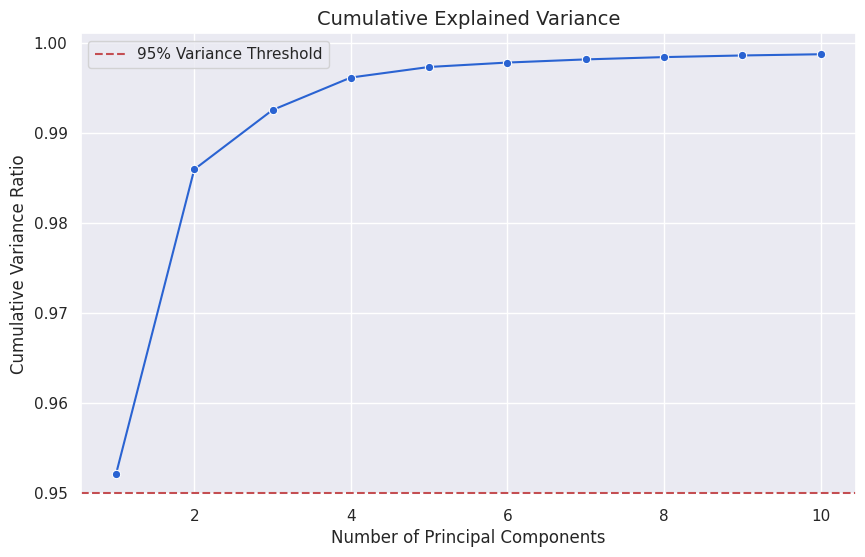

Number of components explaining 95% variance: 1


In [8]:
# 누적 설명 분산 비율 계산
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# 설명 분산 비율 시각화
plt.figure(figsize=(10, 6))
sns.lineplot(x=np.arange(1, len(cumulative_variance_ratio) + 1), y=cumulative_variance_ratio, marker="o", color="#2A63D2")
plt.axhline(y=0.95, color="r", linestyle="--", label="95% Variance Threshold")
plt.title("Cumulative Explained Variance", fontsize=14)
plt.xlabel("Number of Principal Components", fontsize=12)
plt.ylabel("Cumulative Variance Ratio", fontsize=12)
plt.legend()
plt.show()

# 최적의 주성분 개수 찾기
optimal_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Number of components explaining 95% variance: {optimal_components}")

# (PCA) 최적의 PC 조합을 구하기

In [9]:
from itertools import combinations
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

# PCA 수행 (이미 스케일링된 데이터를 사용한다고 가정)
pca = PCA(n_components=10)  # 상위 10개의 주성분 계산
principal_components = pca.fit_transform(X_train_scaled)
pca_df = pd.DataFrame(principal_components, columns=[f"PC{i+1}" for i in range(10)])

# 누적 설명 분산 비율 확인
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# 최적의 조합 탐색 (최소 2개에서 최대 5개의 주성분 조합)
best_score = 0
best_combination = None

for r in range(2, 6):  # 최소 2개 ~ 최대 5개의 주성분 선택
    for combination in combinations(pca_df.columns, r):
        X_comb = pca_df[list(combination)]

        # XGBoost 모델 사용하여 5-fold 교차 검증
        scores = cross_val_score(
            XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
            X_comb, y_train_resampled, cv=5, scoring='accuracy'
        )
        avg_score = np.mean(scores)

        # 최적의 조합 및 스코어 저장
        if avg_score > best_score:
            best_score = avg_score
            best_combination = combination

# 결과 출력
print("Best Combination of Principal Components:", best_combination)
print("Best Cross-Validation Accuracy Score:", best_score)

# 최적 조합 데이터 생성
X_train_pca_optimal = pca_df[list(best_combination)]

Best Combination of Principal Components: ('PC2', 'PC5', 'PC7', 'PC9', 'PC10')
Best Cross-Validation Accuracy Score: 0.9362068965517242


# Data Sampling, Data Scaling에 대한 도식 그리기

Archive:  exoplanets.csv.zip
  inflating: exoplanets.csv          
  inflating: __MACOSX/._exoplanets.csv  
Original Class Distribution:
LABEL
0    363
1     37
Name: count, dtype: int64

Before SMOTE and Tomek Links:
LABEL
0    290
1     30
Name: count, dtype: int64


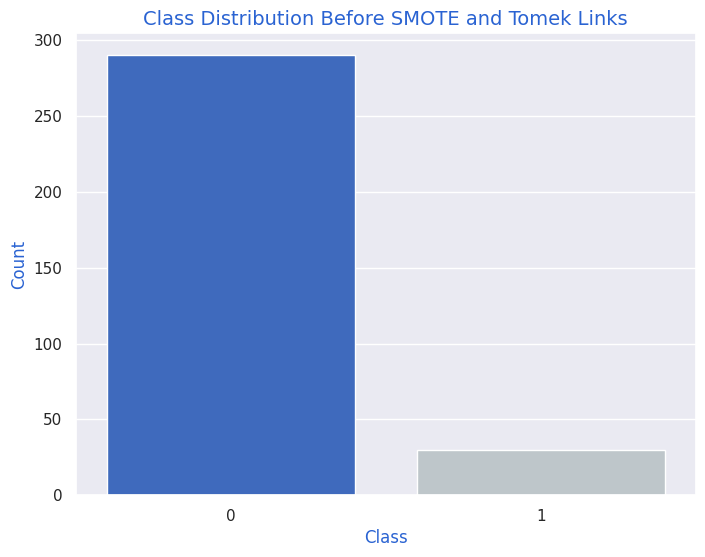


After SMOTE and Tomek Links:
LABEL
0    290
1    290
Name: count, dtype: int64


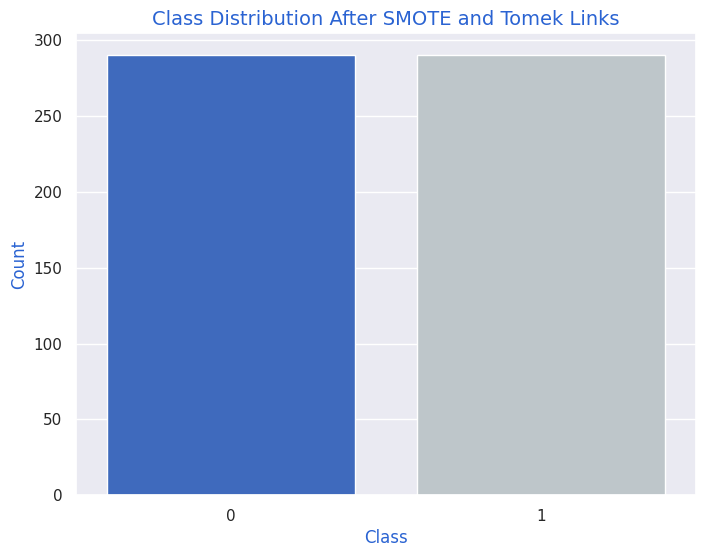


Feature 1 Before Scaling (Sample): count    5.800000e+02
mean     1.155405e+05
std      4.536644e+05
min      1.953000e+01
25%      2.808233e+03
50%      1.226774e+04
75%      2.843000e+04
max      4.047204e+06
Name: 0, dtype: float64

Feature 1 After Scaling (Sample): count    5.800000e+02
mean     4.030664e+00
std      1.770621e+01
min     -4.780391e-01
25%     -3.691980e-01
50%      3.556183e-17
75%      6.308020e-01
max      1.574808e+02
dtype: float64


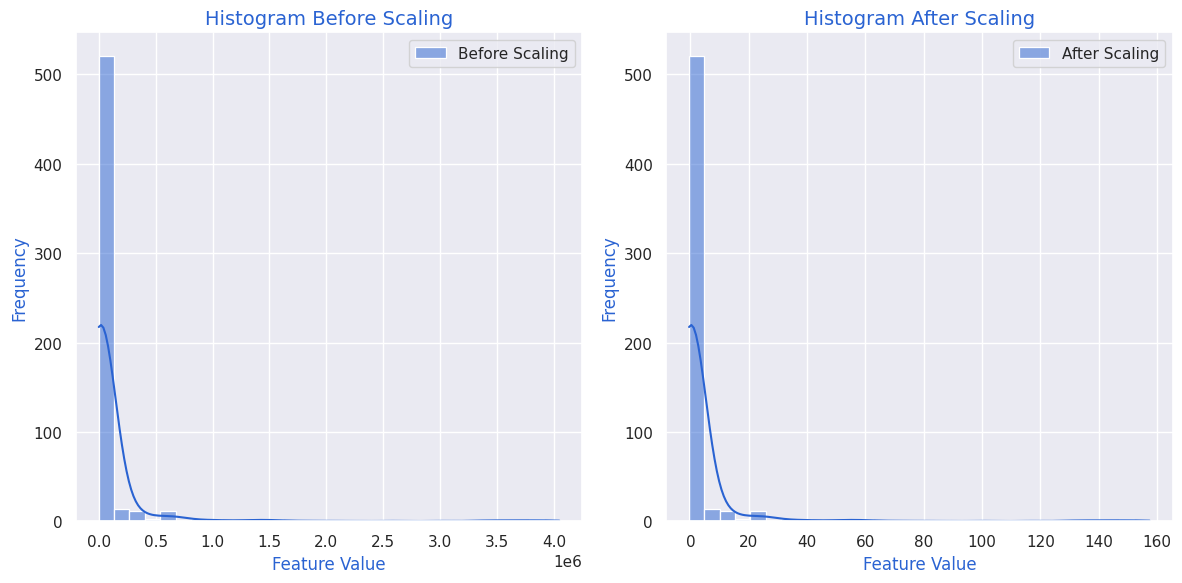

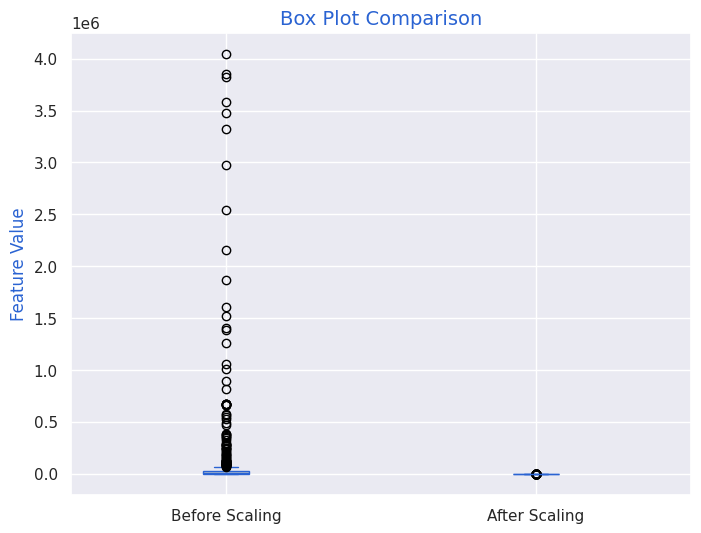

In [7]:
import sys
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy.fft import fft
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV

warnings.filterwarnings('ignore')
sns.set()

# 색상 테마 정의
main_color = "#2A63D2"  # 메인 색상
gray_color = "#BCC6CC"  # 중간 회색

if 'google.colab' in sys.modules:
    !pip install -q --upgrade xgboost
    !wget -q https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter07/exoplanets.csv.zip
!unzip -o exoplanets.csv.zip

xgb.set_config(verbosity=0)

df = pd.read_csv('exoplanets.csv', nrows=400)

# 데이터 준비
X = df.filter(like="FLUX")  # FLUX로 시작하는 열
y = df["LABEL"] - 1  # 타깃 변수 (0, 1)

# 1. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 클래스 분포 시각화 (원본 데이터)
print("Original Class Distribution:")
print(y.value_counts())

# 2. FFT 수행 및 진폭 계산
fft_train_data = []
fft_test_data = []

for i in range(X_train.shape[0]):
    sample_flux = X_train.iloc[i, :]
    fft_result = fft(sample_flux.to_numpy())
    magnitude = np.abs(fft_result[:len(sample_flux) // 2])
    fft_train_data.append(magnitude)

for i in range(X_test.shape[0]):
    sample_flux = X_test.iloc[i, :]
    fft_result = fft(sample_flux.to_numpy())
    magnitude = np.abs(fft_result[:len(sample_flux) // 2])
    fft_test_data.append(magnitude)

fft_train_df = pd.DataFrame(fft_train_data)
fft_test_df = pd.DataFrame(fft_test_data)

# 3. SMOTE + Tomek Links
print("\nBefore SMOTE and Tomek Links:")
print(y_train.value_counts())

# 시각화 - SMOTE 및 Tomek Links 적용 전
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train, palette=[main_color, gray_color])
plt.title("Class Distribution Before SMOTE and Tomek Links", color=main_color, fontsize=14)
plt.xlabel("Class", color=main_color)
plt.ylabel("Count", color=main_color)
plt.show()

# SMOTE 및 Tomek Links 적용
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(fft_train_df, y_train)

# 시각화 - SMOTE 및 Tomek Links 적용 후
print("\nAfter SMOTE and Tomek Links:")
print(pd.Series(y_train_resampled).value_counts())

plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_resampled, palette=[main_color, gray_color])
plt.title("Class Distribution After SMOTE and Tomek Links", color=main_color, fontsize=14)
plt.xlabel("Class", color=main_color)
plt.ylabel("Count", color=main_color)
plt.show()

# 4. RobustScaler 적용
original_data = X_train_resampled.iloc[:, 0]  # 첫 번째 특성

# 스케일링 전후 시각화
print("\nFeature 1 Before Scaling (Sample):", original_data.describe())

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(original_data, kde=True, bins=30, color=main_color, label="Before Scaling")
plt.title("Histogram Before Scaling", color=main_color, fontsize=14)
plt.xlabel("Feature Value", color=main_color)
plt.ylabel("Frequency", color=main_color)
plt.legend()

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
scaled_data = X_train_scaled[:, 0]

print("\nFeature 1 After Scaling (Sample):", pd.Series(scaled_data).describe())

plt.subplot(1, 2, 2)
sns.histplot(scaled_data, kde=True, bins=30, color=main_color, label="After Scaling")
plt.title("Histogram After Scaling", color=main_color, fontsize=14)
plt.xlabel("Feature Value", color=main_color)
plt.ylabel("Frequency", color=main_color)
plt.legend()
plt.tight_layout()
plt.show()

# 박스 플롯 비교
plt.figure(figsize=(8, 6))
plt.boxplot(
    [original_data, scaled_data],
    labels=["Before Scaling", "After Scaling"],
    showfliers=True,
    patch_artist=True,
    boxprops=dict(facecolor=gray_color, color=main_color),
    medianprops=dict(color=main_color),
    whiskerprops=dict(color=main_color),
    capprops=dict(color=main_color)
)
plt.title("Box Plot Comparison", color=main_color, fontsize=14)
plt.ylabel("Feature Value", color=main_color)
plt.show()

# Stratified K-Fold 도식화하기

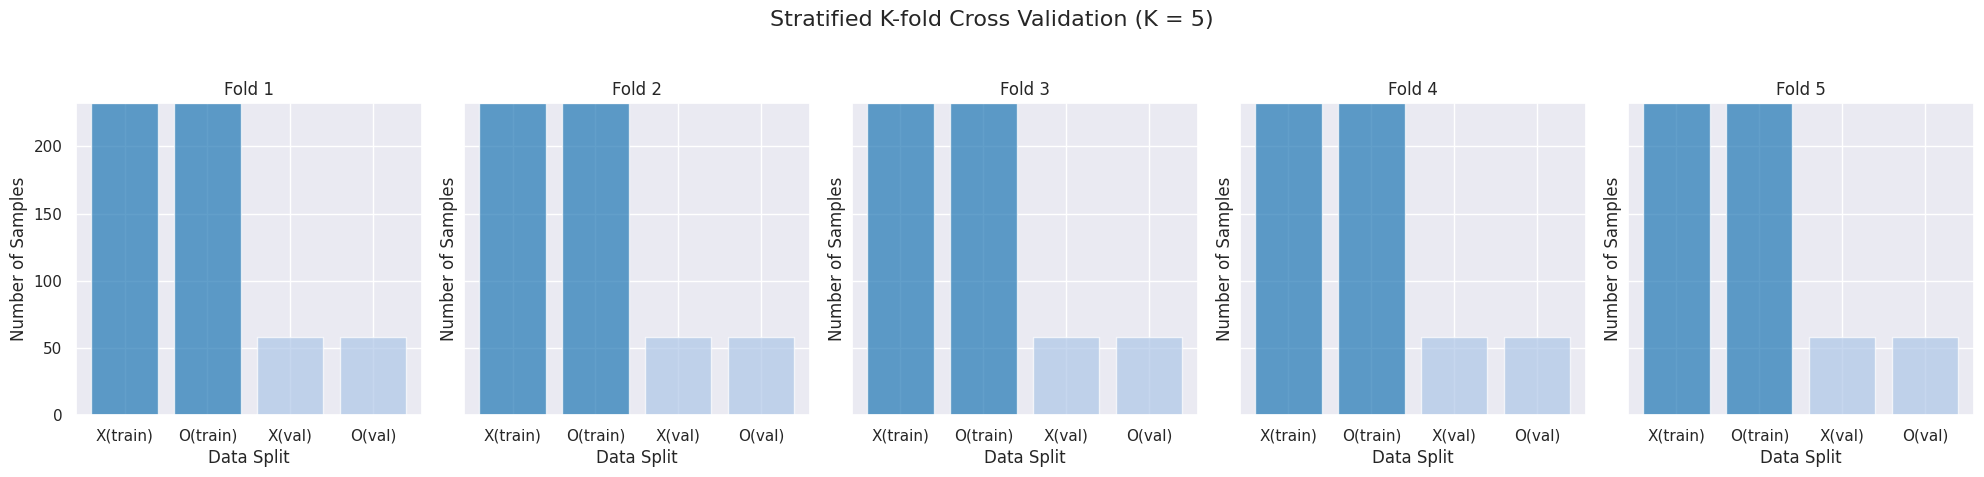

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

# Stratified K-Fold 설정
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 데이터를 사용하여 각 폴드 시각화
X_train_pca_selected = X_train_pca_selected.reset_index(drop=True)
y_train_resampled = y_train_resampled.reset_index(drop=True)

fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
fig.suptitle('Stratified K-fold Cross Validation (K = 5)', fontsize=16)

colors = ['#1f77b4', '#aec7e8']  # 진한 파랑과 연한 파랑

for i, (train_index, val_index) in enumerate(skf.split(X_train_pca_selected, y_train_resampled)):
    axes[i].set_title(f'Fold {i + 1}')
    train_labels = y_train_resampled.iloc[train_index]
    val_labels = y_train_resampled.iloc[val_index]

    # 훈련 데이터 시각화
    axes[i].bar(['X(train)', 'O(train)'], [sum(train_labels == 0), sum(train_labels == 1)], color=colors[0], alpha=0.7)
    # 검증 데이터 시각화
    axes[i].bar(['X(val)', 'O(val)'], [sum(val_labels == 0), sum(val_labels == 1)], color=colors[1], alpha=0.7)

    axes[i].set_ylim(0, len(y_train_resampled) * 0.4)
    axes[i].set_ylabel('Number of Samples')
    axes[i].set_xlabel('Data Split')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [17]:
from itertools import combinations
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

# PCA 수행 (이미 스케일링된 데이터를 사용한다고 가정)
pca = PCA(n_components=10)  # 상위 10개의 주성분 계산
principal_components = pca.fit_transform(X_train_scaled)
pca_df = pd.DataFrame(principal_components, columns=[f"PC{i+1}" for i in range(10)])

# 누적 설명 분산 비율 확인
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# 최적의 조합 탐색 (최소 2개에서 최대 5개의 주성분 조합)
best_score = 0
best_combination = None

for r in range(2, 6):  # 최소 2개 ~ 최대 5개의 주성분 선택
    for combination in combinations(pca_df.columns, r):
        X_comb = pca_df[list(combination)]

        # XGBoost 모델 사용하여 5-fold 교차 검증 (재현율 사용)
        scores = cross_val_score(
            XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
            X_comb, y_train_resampled, cv=5, scoring='recall'
        )
        avg_score = np.mean(scores)

        # 최적의 조합 및 스코어 저장
        if avg_score > best_score:
            best_score = avg_score
            best_combination = combination

# 결과 출력
print("Best Combination of Principal Components:", best_combination)
print("Best Cross-Validation Recall Score:", best_score)

# 최적 조합 데이터 생성
X_train_pca_optimal = pca_df[list(best_combination)]

Best Combination of Principal Components: ('PC2', 'PC5', 'PC7', 'PC9', 'PC10')
Best Cross-Validation Recall Score: 0.9482758620689655


# 5개의 PC 조합만 다시 Best Combanation 탐색

In [21]:
from itertools import combinations
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

# PCA 수행 (이미 스케일링된 데이터를 사용한다고 가정)
pca = PCA(n_components=10)  # 상위 10개의 주성분 계산
principal_components = pca.fit_transform(X_train_scaled)
pca_df = pd.DataFrame(principal_components, columns=[f"PC{i+1}" for i in range(10)])

# 누적 설명 분산 비율 확인
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# 최적의 5개 조합 탐색
y_train_resampled = y_train_resampled.reset_index(drop=True)  # 인덱스 리셋
best_score = 0
best_combination = None

# 5개의 주성분만 선택하여 조합 탐색
for combination in combinations(pca_df.columns, 5):
    X_comb = pca_df[list(combination)]

    # XGBoost 모델 사용하여 5-fold 교차 검증 (재현율 사용)
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=5)  # 클래스 불균형 해결을 위한 가중치 부여
    scores = cross_val_score(
        model,
        X_comb, y_train_resampled, cv=5, scoring='recall_weighted'
    )
    avg_score = np.mean(scores)

    # 최적의 조합 및 스코어 저장
    if avg_score > best_score:
        best_score = avg_score
        best_combination = combination

# 결과 출력
print("Best Combination of Principal Components:", best_combination)
print("Best Cross-Validation Recall Score:", best_score)

# 최적 조합 데이터 생성
X_train_pca_optimal = pca_df[list(best_combination)]
X_test_pca_selected = X_test_pca_df[list(best_combination)]

Best Combination of Principal Components: ('PC1', 'PC2', 'PC5', 'PC9', 'PC10')
Best Cross-Validation Recall Score: 0.9344827586206896
